In [1]:
library(data.table)
library(tidyverse)
library(DESeq2)
library(rtracklayer)
library(dplyr)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()

In [3]:
packageVersion("DESeq2")

[1] ‘1.46.0’

In [1]:
# For this script to run; load in the barcodes from the TUMOUR only cells form each timepoint. This is done is "cluster_tumour_only.ipynb"

In [4]:
path_barcodes <- file.path("/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/barcodes_tumour_cells_D0.tsv")

# Get the list of files in the directory, including their full paths
barcodes <- read.delim(path_barcodes, header = FALSE)
barcodes$V1 <- gsub("-D0","",barcodes$V1)

In [ ]:
raw_count_D0 <- read.table("/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/scnanoseq/results/D0/isoquant/D0.gene_counts.tsv", header =1)
head(raw_count_D0)

In [6]:
D0 <- barcodes
count <- raw_count_D0 %>% dplyr::select(which(colnames(raw_count_D0) %in% D0$V1))

In [7]:
process_raw_counts <- function(raw_counts, D0) {
  # Set row names and remove the first column
  rownames(raw_counts) <- raw_counts$feature_id
  raw_counts <- raw_counts[, -1]
  
  # Remove columns that match `D0_V1`
  raw_counts <- raw_counts %>%
    dplyr::select(which(colnames(raw_counts) %in% D0$V1))
  
  # Add a new column `D0` with row sums
  raw_counts$D0 <- rowSums(raw_counts)
  
  # Return a data frame with only the `D0` column
  D0 <- raw_counts %>% select(D0)
  return(D0)
}


In [8]:
raw_count_Q1 <- read.table("/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/scnanoseq/results/Q1/isoquant/Q1.gene_counts.tsv", header =1)
#Cropt the barcodes of the tag
path_barcodes <- file.path("/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/barcodes_tumour_cells_Q1.tsv")

# Get the list of files in the directory, including their full paths
barcodes <- read.delim(path_barcodes, header = FALSE)
barcodes$V1 <- gsub("-Q1","",barcodes$V1)
Q1 <-barcodes


raw_count_Q2 <- read.table("/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/scnanoseq/results/Q2/isoquant/Q2.gene_counts.tsv", header =1)
#Cropt the barcodes of the tag
path_barcodes <- file.path("/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/barcodes_tumour_cells_Q2.tsv")

# Get the list of files in the directory, including their full paths
barcodes <- read.delim(path_barcodes, header = FALSE)
barcodes$V1 <- gsub("-Q2","",barcodes$V1)
Q2 <-barcodes


raw_count_Q3 <- read.table("/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/scnanoseq/results/Q3/isoquant/Q3.gene_counts.tsv", header =1)
#Cropt the barcodes of the tag
path_barcodes <- file.path("/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/barcodes_tumour_cells_Q3.tsv")

# Get the list of files in the directory, including their full paths
barcodes <- read.delim(path_barcodes, header = FALSE)
barcodes$V1 <- gsub("-Q3","",barcodes$V1)
Q3 <-barcodes


In [9]:
# Function to divide the single cell dataframe in 5 random frames:
split_into_groups <- function(df, num_groups = 5, seed =123){
    barcode_cols <- setdiff(names(df), "feature_id") # I want all the barcodes but not feature_id
    set.seed(seed)

    barcode_cols <- sample(barcode_cols) #shuffle the barcodes to create random sets

    group_size <- ceiling(length(barcode_cols) / num_groups) #Split into groups
    groups <- split(barcode_cols, ceiling(1:length(barcode_cols) / group_size)) #Now make the groups

    grouped_dfs <- lapply(groups, function(cols) df[, c("feature_id", cols)]) #Make a data.table out of it

    return(grouped_dfs)   
}

In [10]:
grouped_data_D0 <- split_into_groups(raw_count_D0, num_groups = 3, seed=123)
D0_bulk <- lapply(names(grouped_data_D0), function(sample_name) {
  # Get the corresponding group (x) from 'grouped_data_D0'
  x <- grouped_data_D0[[sample_name]]
    processed <- process_raw_counts(x, D0)
  
    colnames(processed) <- paste0("D0_", sample_name)
  
  return(processed)
})

grouped_data_Q1 <- split_into_groups(raw_count_Q1, num_groups = 3, seed=123)
Q1_bulk <- lapply(names(grouped_data_Q1), function(sample_name) {
  # Get the corresponding group (x) from 'grouped_data_D0'
  x <- grouped_data_Q1[[sample_name]]
    processed <- process_raw_counts(x, Q1)
  
    colnames(processed) <- paste0("Q1_", sample_name)
  
  return(processed)
})

grouped_data_Q2 <- split_into_groups(raw_count_Q2, num_groups = 3, seed=123)
Q2_bulk <- lapply(names(grouped_data_Q2), function(sample_name) {
  # Get the corresponding group (x) from 'grouped_data_D0'
  x <- grouped_data_Q2[[sample_name]]
    processed <- process_raw_counts(x, Q2)
  
    colnames(processed) <- paste0("Q2_", sample_name)
  
  return(processed)
})

grouped_data_Q3 <- split_into_groups(raw_count_Q3, num_groups = 3, seed=123)
Q3_bulk <- lapply(names(grouped_data_Q3), function(sample_name) {
  # Get the corresponding group (x) from 'grouped_data_D0'
  x <- grouped_data_Q3[[sample_name]]
    processed <- process_raw_counts(x, Q3)
  
    colnames(processed) <- paste0("Q3_", sample_name)
  
  return(processed)
})

In [11]:
for (i in 1:length(D0_bulk)) {
  var_name <- paste0("D0_", i)
  
  # Assign the data frame to the variable name
  assign(var_name, D0_bulk[[i]])
  df <- get(var_name)  # Get the data frame by its dynamically created name
  df <- rownames_to_column(df, var = "Row.names")  # Convert row names to column
  
  # Re-assign the modified data frame back to the variable
  assign(var_name, df)
}

for (i in 1:length(Q1_bulk)) {
  var_name <- paste0("Q1_", i)
  
  # Assign the data frame to the variable name
  assign(var_name, Q1_bulk[[i]])
  df <- get(var_name)  # Get the data frame by its dynamically created name
  df <- rownames_to_column(df, var = "Row.names")  # Convert row names to column
  
  # Re-assign the modified data frame back to the variable
  assign(var_name, df)
}

for (i in 1:length(Q2_bulk)) {
  var_name <- paste0("Q2_", i)
  
  # Assign the data frame to the variable name
  assign(var_name, Q2_bulk[[i]])
  df <- get(var_name)  # Get the data frame by its dynamically created name
  df <- rownames_to_column(df, var = "Row.names")  # Convert row names to column
  
  # Re-assign the modified data frame back to the variable
  assign(var_name, df)
}

for (i in 1:length(Q3_bulk)) {
  var_name <- paste0("Q3_", i)
  
  # Assign the data frame to the variable name
  assign(var_name, Q3_bulk[[i]])
  df <- get(var_name)  # Get the data frame by its dynamically created name
  df <- rownames_to_column(df, var = "Row.names")  # Convert row names to column
  
  # Re-assign the modified data frame back to the variable
  assign(var_name, df)
}

In [12]:
bulk_D0_Q1 <- Reduce(function(x, y) merge(x, y, by = "Row.names"),
               list(D0_1, D0_2,D0_3 ,Q1_1, Q1_2, Q1_3, Q2_1,Q2_2,Q2_3,Q3_1,Q3_2,Q3_3))

rownames(bulk_D0_Q1 ) <- bulk_D0_Q1$Row.names
bulk_D0_Q1  <- bulk_D0_Q1 [, -1]

# Now that we have Pseudobulk we can compare 1 sample vs the others:


In [192]:
sample <- "Q3"

In [193]:
if (sample == "D0") {
  condition <- c("treated", "treated", "treated", 
                 "untreated", "untreated", "untreated",
                 "untreated", "untreated", "untreated",
                 "untreated", "untreated", "untreated")
  
} else if (sample == "Q1") {
  condition <- c("untreated", "untreated", "untreated", 
                 "treated", "treated", "treated",
                 "untreated", "untreated", "untreated",
                 "untreated", "untreated", "untreated")
  
} else if (sample == "Q2") {
  condition <- c("untreated", "untreated", "untreated", 
                 "untreated", "untreated", "untreated",
                 "treated", "treated", "treated",
                 "untreated", "untreated", "untreated")
  
} else if (sample == "Q3") {
  condition <- c("untreated", "untreated", "untreated", 
                 "untreated", "untreated", "untreated",
                 "untreated", "untreated", "untreated",
                 "treated", "treated", "treated")
  
} else {
  stop("Sample must be one of: 'D0', 'Q1', 'Q2', 'Q3'")
}



In [194]:
 condition

[1] "untreated" "untreated" "untreated" "untreated" "untreated" "untreated"
 [7] "untreated" "untreated" "untreated" "treated"   "treated"   "treated"

In [195]:
#Start with D0 vs rest on bulk level:
samples <- colnames(bulk_D0_Q1)
condition <- condition
               

# Create the coldata data frame (without duplicate row names)
coldata <- data.frame(sample = samples, condition = condition, row.names = samples)

# View the data frame
print(coldata)


     sample condition
D0_1   D0_1 untreated
D0_2   D0_2 untreated
D0_3   D0_3 untreated
Q1_1   Q1_1 untreated
Q1_2   Q1_2 untreated
Q1_3   Q1_3 untreated
Q2_1   Q2_1 untreated
Q2_2   Q2_2 untreated
Q2_3   Q2_3 untreated
Q3_1   Q3_1   treated
Q3_2   Q3_2   treated
Q3_3   Q3_3   treated


In [196]:
bulk_D0_Q1 <- as.matrix(bulk_D0_Q1)
bulk_D0_Q1[] <- as.integer(bulk_D0_Q1)

In [197]:
dds <- DESeqDataSetFromMatrix(countData = bulk_D0_Q1,
                              colData = coldata,
                              design = ~ condition)
dds

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 36601 12 
metadata(1): version
assays(1): counts
rownames(36601): ENSG00000000003 ENSG00000000005 ... ENSG00000288459
  ENSG00000288460
rowData names(0):
colnames(12): D0_1 D0_2 ... Q3_2 Q3_3
colData names(2): sample condition

In [198]:
keep <- rowSums(counts(dds) >= 10) >= 1
dds <- dds[keep,]
dds

class: DESeqDataSet 
dim: 17344 12 
metadata(1): version
assays(1): counts
rownames(17344): ENSG00000000003 ENSG00000000419 ... ENSG00000288380
  ENSG00000288398
rowData names(0):
colnames(12): D0_1 D0_2 ... Q3_2 Q3_3
colData names(2): sample condition

In [199]:
dds$condition <- relevel(dds$condition, ref = "untreated")
dds <- DESeq(dds)
res <- results(dds, contrast=c("condition", "treated", "untreated"), alpha=0.05)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [200]:
GFFfile <- readGFF("/staging/leuven/stg_00096/references/GRCh38.alt-masked-V2-noALT/annotation/gencode.v43.basic.annotation.gtf")
GFFfile <- GFFfile %>% select(gene_name, gene_id)
GFFfile <- GFFfile %>%
  mutate(gene_id = sapply(str_split(gene_id, "\\."), function(x) x[1]))
GFFfile <- GFFfile[!duplicated(GFFfile$gene_name), ]
head(GFFfile)

,gene_name,gene_id
,<chr>,<chr>
1,DDX11L2,ENSG00000290825
6,DDX11L1,ENSG00000223972
14,WASH7P,ENSG00000227232
27,MIR6859-1,ENSG00000278267
30,MIR1302-2HG,ENSG00000243485
38,MIR1302-2,ENSG00000284332


In [ ]:
res_df <- merge(as.data.frame(res), GFFfile, by.x = "row.names", by.y="gene_id")
res_df

In [202]:
resultsNames(dds)
resLFC <- lfcShrink(dds, coef="condition_treated_vs_untreated", type="apeglm")
resLFC

[1] "Intercept"                      "condition_treated_vs_untreated"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): condition treated vs untreated 
Wald test p-value: condition treated vs untreated 
DataFrame with 17344 rows and 5 columns
                 baseMean log2FoldChange     lfcSE     pvalue      padj
                <numeric>      <numeric> <numeric>  <numeric> <numeric>
ENSG00000000003   8.40381      0.0180481  0.234957 0.80588655  0.944085
ENSG00000000419 215.14458     -0.0644811  0.116922 0.52994629  0.835201
ENSG00000000457  39.71826      0.0137780  0.220302 0.89101679  0.969931
ENSG00000000460  28.58725     -0.0100992  0.231846 0.89718044  0.972318
ENSG00000000938  13.44166     -0.3510372  0.727959 0.00997059  0.119841
...                   ...            ...       ...        ...       ...
ENSG00000288156   21.5415      -0.303248  0.435624  0.0387067  0.270588
ENSG00000288162   12.7425       0.108463  0.279474  0.0325723  0.244985
ENSG00000288302   98.7634      -0.203253  0.340753  0.0540917  0.322727
ENSG00000288380   80.5828       0.137792  0.205419  0.3029068

In [ ]:
resOrdered <- res[order(res$pvalue),]
resOrdered_df <- merge(as.data.frame(resOrdered), GFFfile, by.x = "row.names", by.y="gene_id")
resOrdered_df <- resOrdered_df[order(resOrdered_df$padj),]
resOrdered_df

In [204]:
summary(res)


out of 17344 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 313, 1.8%
LFC < 0 (down)     : 567, 3.3%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [205]:
sum(res$padj < 0.05, na.rm=TRUE)

[1] 880

In [206]:
rownames(res) <- sapply(rownames(res), function(x) {
  match_idx <- match(x, GFFfile$gene_id)
  if (!is.na(match_idx)) {
    return(GFFfile$gene_name[match_idx])
  } else {
    return(x)  # Keep original rowname if no match
  }
})

# View the updated `res`
print(res)

log2 fold change (MLE): condition treated vs untreated 
Wald test p-value: condition treated vs untreated 
DataFrame with 17344 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat     pvalue
                <numeric>      <numeric> <numeric> <numeric>  <numeric>
TSPAN6            8.40381      0.1894561  0.770974  0.245736 0.80588655
DPM1            215.14458     -0.0821386  0.130776 -0.628088 0.52994629
SCYL3            39.71826      0.0675493  0.492997  0.137018 0.89101679
C1orf112         28.58725     -0.0871190  0.674171 -0.129224 0.89718044
FGR              13.44166     -1.6175418  0.627721 -2.576847 0.00997059
...                   ...            ...       ...       ...        ...
ENSG00000288156   21.5415      -0.964713  0.466655  -2.06729  0.0387067
ENSG00000288162   12.7425       3.316313  1.551625   2.13732  0.0325723
ENSG00000288302   98.7634      -1.028220  0.533835  -1.92610  0.0540917
ENSG00000288380   80.5828       0.288016  0.279568   1.03022 

In [207]:
library(EnhancedVolcano)
library(pheatmap)

In [208]:
setwd("/staging/leuven/stg_00096/home/projects/2023_Cools_B-ALL/RNA-analysis/final_analysis/output_figures")

In [209]:
top20 <- resOrdered_df$gene_name[1:20]

# Filter out names starting with "ENS"
top20_filtered <- top20[!grepl("^ENS", top20)]

# Select the first 10 from the filtered list
top10 <- top20_filtered[1:10]

# View result
top10

[1] "CD19"     "HSPA1A"   "NFKBIZ"   "LCN6"     "LGALS3BP" "PPP2R5C" 
 [7] "BCAT1"    "ARHGAP27" "HEXIM1"   "ZNF608"

In [210]:
top10_df <- data.frame(gene_name = top10)

# Compose file name with sample variable
file_name <- paste0("top10_", sample, ".txt")

# Write to file
fwrite(top10_df, file_name)

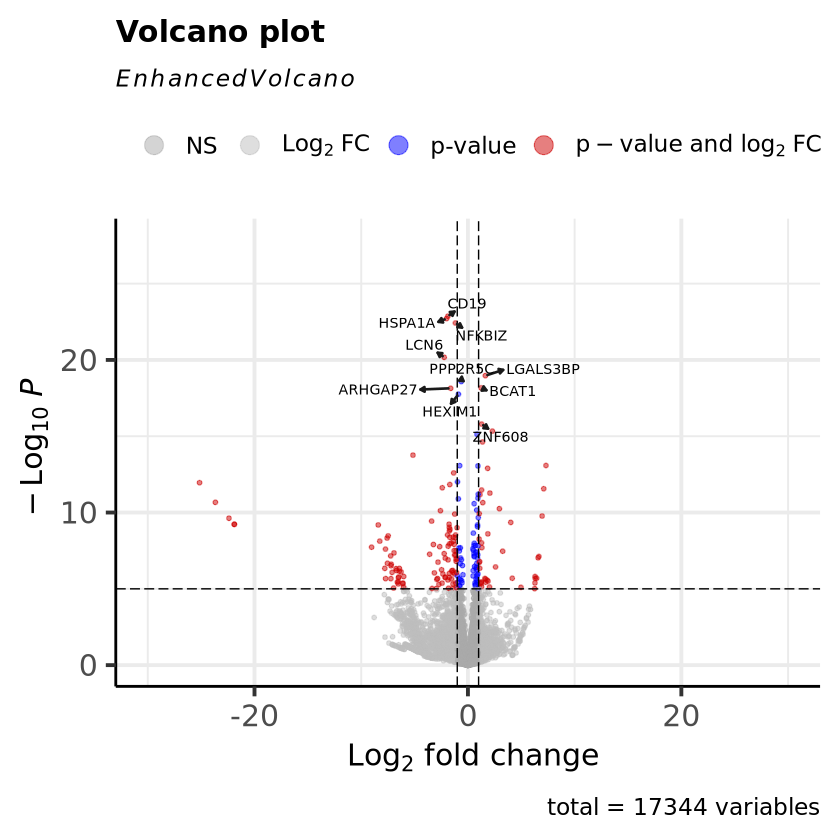

In [211]:
EnhancedVolcano(res, lab=rownames(res), x="log2FoldChange", y="pvalue", xlim=c(-30,30),pointSize = 1.0,colAlpha = 0.5,labSize = 3.0,drawConnectors = TRUE,
    widthConnectors = 0.75,selectLab = top10,col = c('darkgrey', 'grey', 'blue', 'red3'))

In [212]:
log2fc_threshold <- 1
pval_threshold <- 0.000005

keyvals.colour <- rep('darkgrey', length(res$log2FoldChange))
names(keyvals.colour) <- rownames(res)

sig_idx <- res$pvalue < pval_threshold  # logical vector

keyvals.colour[sig_idx & res$log2FoldChange > log2fc_threshold] <- 'red3'
keyvals.colour[sig_idx & res$log2FoldChange < -log2fc_threshold] <- 'royalblue'

names(keyvals.colour)[keyvals.colour == 'red3'] <- 'upregulated'
names(keyvals.colour)[keyvals.colour == 'darkgrey'] <- 'downregulated'
names(keyvals.colour)[keyvals.colour == 'royalblue'] <- 'not-sig'



In [213]:
# Create volcano plot
p <- EnhancedVolcano(res,
  lab = rownames(res),
  x = 'log2FoldChange',
  y = 'pvalue',
  xlim = c(-25, 25),
  pointSize = 1.0,
  colAlpha = 0.5,
  labSize = 3,
  colCustom = keyvals.colour,
  drawConnectors = TRUE,
  widthConnectors = 0.5,
  selectLab = top10,
  title = paste0('Volcano Plot_', sample,"vs_rest")
)

In [214]:

pdf(paste0("Volcano_plot_",sample,"_vs_rest.pdf"), width = 7, height = 7)
print(p)  # Important: use print() to render ggplot inside pdf()
dev.off()

pdf 
  2

In [215]:
# Transform/ Normalise the data
vsd <- vst(dds, blind=FALSE)
rld <- rlog(dds, blind=FALSE)
head(assay(vsd), 3)

,D0_1,D0_2,D0_3,Q1_1,Q1_2,Q1_3,Q2_1,Q2_2,Q2_3,Q3_1,Q3_2,Q3_3
ENSG00000000003,5.448613,5.198343,4.720984,4.517738,4.642394,4.363823,4.254213,4.238378,4.074717,4.358212,4.827604,5.068886
ENSG00000000419,7.871891,8.059231,7.925629,7.848232,7.956999,7.879611,8.045944,7.564877,7.997441,7.837172,7.770275,7.902622
ENSG00000000457,5.850786,6.246420,6.269240,6.204868,6.368430,6.000546,5.212306,5.452968,4.710288,6.293140,5.902824,5.619942


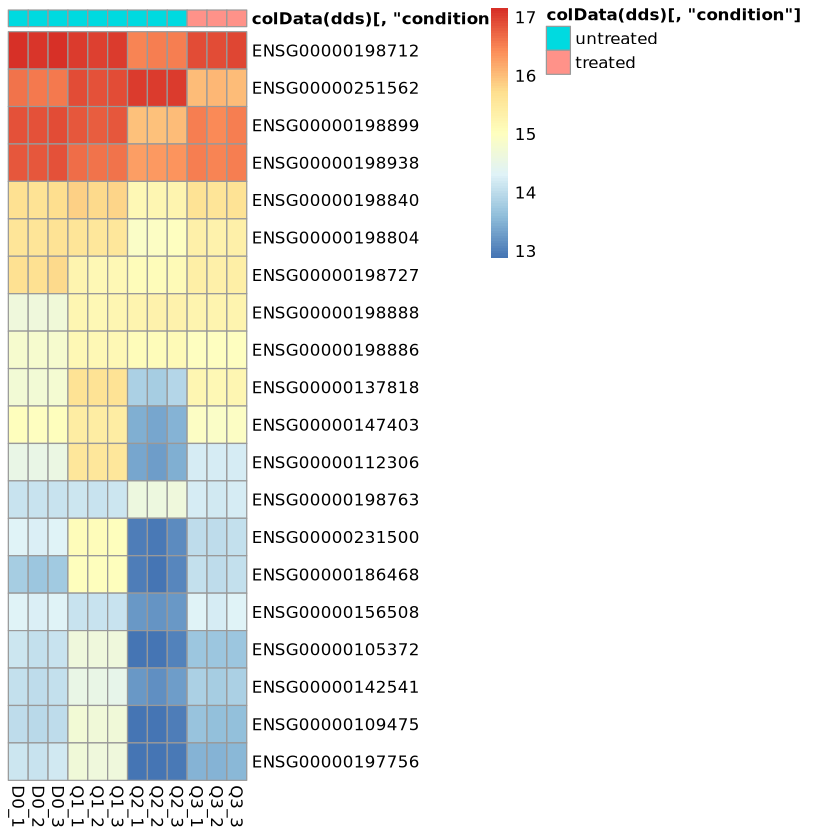

In [216]:
# Select the top 20 most variable genes based on row means of normalized counts
select <- order(rowMeans(counts(dds, normalized = TRUE)), decreasing = TRUE)[1:20]
# Create a dataframe for column annotations (e.g., condition)
df <- as.data.frame(colData(dds)[, "condition"])
rownames(df) <- colnames(bulk_D0_Q1)
# Perform the transformation (e.g., rlog or vst) if needed for better visualization
ntd <- vst(dds, blind = FALSE)  # Use rlog or vst depending on your needs

# Create a heatmap using pheatmap
pheatmap(assay(ntd)[select, ], 
         cluster_rows = FALSE, 
         show_rownames = TRUE,
         cluster_cols = FALSE, 
         annotation_col = df)

using ntop=500 top features by variance



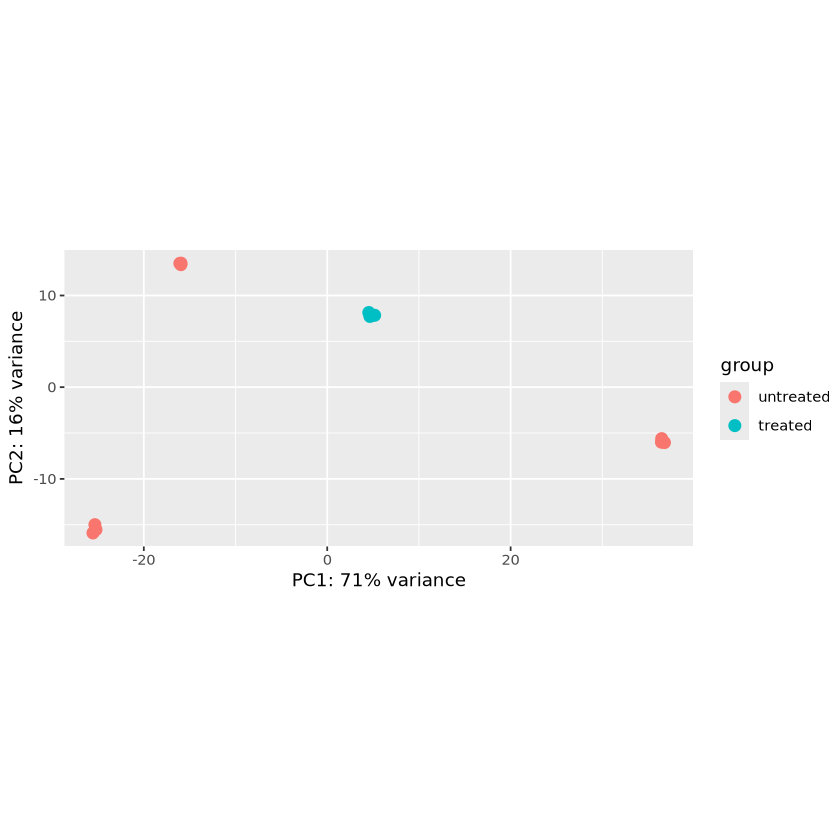

In [217]:
plotPCA(vsd, intgroup=("condition"))

In [218]:
#GSEA
res

log2 fold change (MLE): condition treated vs untreated 
Wald test p-value: condition treated vs untreated 
DataFrame with 17344 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat     pvalue
                <numeric>      <numeric> <numeric> <numeric>  <numeric>
TSPAN6            8.40381      0.1894561  0.770974  0.245736 0.80588655
DPM1            215.14458     -0.0821386  0.130776 -0.628088 0.52994629
SCYL3            39.71826      0.0675493  0.492997  0.137018 0.89101679
C1orf112         28.58725     -0.0871190  0.674171 -0.129224 0.89718044
FGR              13.44166     -1.6175418  0.627721 -2.576847 0.00997059
...                   ...            ...       ...       ...        ...
ENSG00000288156   21.5415      -0.964713  0.466655  -2.06729  0.0387067
ENSG00000288162   12.7425       3.316313  1.551625   2.13732  0.0325723
ENSG00000288302   98.7634      -1.028220  0.533835  -1.92610  0.0540917
ENSG00000288380   80.5828       0.288016  0.279568   1.03022 

In [219]:
res <- res[order(-res$stat),]

In [220]:
library(org.Hs.eg.db)

In [221]:
gene_list <- res$stat
names(gene_list) <- rownames(res)
# omit any NA values 
gene_list<-na.omit(gene_list)

# sort the list in decreasing order (required for clusterProfiler)
gene_list = sort(gene_list, decreasing = TRUE)


In [222]:
library(clusterProfiler)

In [223]:
library(org.Hs.eg.db)
library(AnnotationDbi)

In [224]:
organism <- org.Hs.eg.db

In [225]:
print(class(org.Hs.eg.db))
keytypes(org.Hs.eg.db)


[1] "OrgDb"
attr(,"package")
[1] "AnnotationDbi"


[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MAP"         
[16] "OMIM"         "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"        
[21] "PMID"         "PROSITE"      "REFSEQ"       "SYMBOL"       "UCSCKG"      
[26] "UNIPROT"

In [226]:
gene_list

LGALS3BP             BCAT1            ZNF608   ENSG00000259001 
     9.081337e+00      8.880235e+00      8.248558e+00      8.121069e+00 
             NAV1              COCH   ENSG00000253134          HSD17B11 
     8.063484e+00      7.920544e+00      7.466083e+00      7.457084e+00 
             MAP9   ENSG00000253976              PPA1            PRDM15 
     7.409291e+00      6.989422e+00      6.962557e+00      6.896446e+00 
             SND1             VMA21            MAP7D3            SYCP2L 
     6.871367e+00      6.863741e+00      6.788185e+00      6.689221e+00 
           IMPDH2              TP63             TARS1              XPOT 
     6.665902e+00      6.553909e+00      6.522495e+00      6.441528e+00 
  ENSG00000228318             PHGDH             ITGA8             IARS1 
     6.386595e+00      6.348831e+00      6.237314e+00      6.178421e+00 
           ATP11C           HNRNPA1              LGR6            UTP14A 
     6.137202e+00      5.979969e+00      5.962458e+00      5.831544e+00 
            PGAM5           UBASH3B             BEND4              SSR2 
     5.735408e+00      5.724877e+00      5.671803e+00      5.666002e+00 
          ZNF280C               IDS            EIF2S3              LAT2 
     5.663402e+00      5.611987e+00      5.583124e+00      5.544611e+00 
            ACSL6          ARHGEF10               EMB           RSL24D1 
     5.518322e+00      5.497010e+00      5.487303e+00      5.451510e+00 
            SOCS4             OVCH2   ENSG00000228988          HSP90AB1 
     5.421576e+00      5.389468e+00      5.377318e+00      5.369897e+00 
  ENSG00000244332            MTHFD2              PCLO             HIPK2 
     5.342408e+00      5.329999e+00      5.236168e+00      5.209652e+00 
             WDR3          HLA-DQA2             TMCC2            ANP32E 
     5.184915e+00      5.095868e+00      5.085136e+00      5.070825e+00 
           ERGIC1             LYRM7            RSL1D1              TPM4 
     5.064665e+00      5.047044e+00      5.011292e+00      4.978920e+00 
            VDAC1          SLC25A14           ZNF518B             PRKDC 
     4.879137e+00      4.859458e+00      4.820504e+00      4.819687e+00 
  ENSG00000232197             BALR6         KIF25-AS1         B4GAT1-DT 
     4.804048e+00      4.752793e+00      4.750689e+00      4.749030e+00 
             CCL5              NOS2         LINC00958              SNCA 
     4.744823e+00      4.729019e+00      4.723640e+00      4.692516e+00 
            PDCD2             EPAS1              KIF9            ZDHHC9 
     4.689479e+00      4.659737e+00      4.637090e+00      4.633327e+00 
             DTX1              LAX1   ENSG00000249752             CSPP1 
     4.627809e+00      4.620216e+00      4.607439e+00      4.604858e+00 
             GDE1              IL1B             CUL4B           STXBP5L 
     4.586075e+00      4.559666e+00      4.523857e+00      4.485759e+00 
        VLDLR-AS1             UFSP2           RAP1GAP            TSEN15 
     4.477106e+00      4.476037e+00      4.465239e+00      4.426346e+00 
           TRIM10            CEP350   ENSG00000270103             NOP16 
     4.423422e+00      4.407798e+00      4.404438e+00      4.399854e+00 
          SLC35B4           PYROXD1           ARHGEF6           SINHCAF 
     4.389457e+00      4.379337e+00      4.361340e+00      4.355547e+00 
           DOCK11             TRPC5            SLC1A5             F13A1 
     4.353651e+00      4.346853e+00      4.340112e+00      4.324872e+00 
             DAP3              SOX6          ATP6V0E2             MOB1A 
     4.322743e+00      4.317870e+00      4.300810e+00      4.291691e+00 
          SLC7A11             SNAI1              RTL6            ZNF121 
     4.279899e+00      4.261162e+00      4.241987e+00      4.238884e+00 
           ADGRA3   ENSG00000257386            KLHL23             ACBD6 
     4.227401e+00      4.220895e+00      4.218869e+00      4.212559e+00 
         KIAA1958            ZNF511             HSPG2            FA

In [227]:
gse <- gseGO(geneList=gene_list, 
             ont ="MF", 
             keyType = "SYMBOL",  
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.05, 
             verbose = TRUE, 
             OrgDb = organism, 
             pAdjustMethod = "none",
             eps = 1e-300)

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.01% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


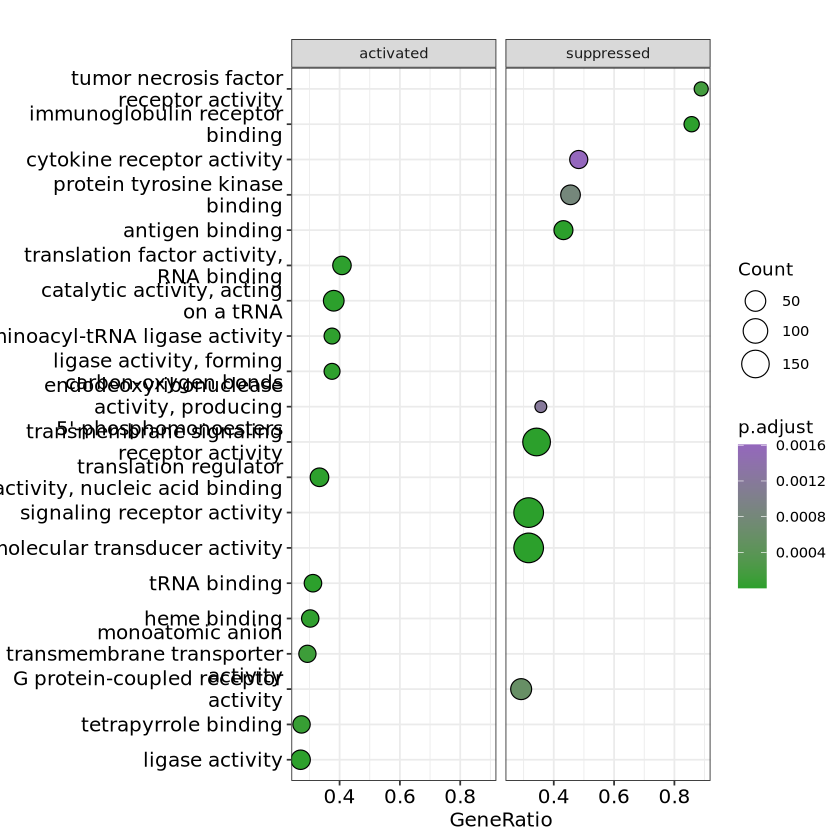

In [229]:
require(DOSE)
p <- dotplot(gse, showCategory=10, split=".sign") + 
     facet_grid(.~.sign) + 
     scale_fill_gradient(low = "#2ca02c", high = "#9467bd")
p

In [230]:
pdf(paste0("GSEA_",sample,"_vs_rest_MF.pdf"), width = 7, height = 7)
print(p)  # Important: use print() to render ggplot inside pdf()
dev.off()

pdf 
  2

In [231]:
gse <- gseGO(geneList=gene_list, 
             ont ="BP", 
             keyType = "SYMBOL",  
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.05, 
             verbose = TRUE, 
             OrgDb = organism, 
             pAdjustMethod = "none",
             eps = 1e-300)

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.01% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
leading edge analysis...

done...



In [232]:
require(DOSE)
p <- dotplot(gse, showCategory=10, split=".sign") + 
     facet_grid(.~.sign) + 
     scale_fill_gradient(low = "#2ca02c", high = "#9467bd")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


In [233]:
pdf(paste0("GSEA_",sample,"_vs_rest_BP.pdf"), width = 7, height = 7)
print(p)  # Important: use print() to render ggplot inside pdf()
dev.off()

pdf 
  2

In [234]:
gse <- gseGO(geneList=gene_list, 
             ont ="CC", 
             keyType = "SYMBOL", 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.05, 
             verbose = TRUE, 
             OrgDb = organism, 
             pAdjustMethod = "none",
             eps = 1e-300)

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.01% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
leading edge analysis...

done...



In [235]:
require(DOSE)
p <- dotplot(gse, showCategory=10, split=".sign") + 
     facet_grid(.~.sign) + 
     scale_fill_gradient(low = "#2ca02c", high = "#9467bd")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


In [236]:
pdf(paste0("GSEA_",sample,"_vs_rest_CC.pdf"), width = 7, height = 7)
print(p)  # Important: use print() to render ggplot inside pdf()
dev.off()

pdf 
  2